### Equity Market Neutral (`100/100`)

We now consider a market neutral strategy targeting 0 market exposure, while targeting absolute returns over a cash benchmark. We use an inverse volatility portfolio optimisation, and use the same alpha model construction as seen in `./alpha_extension.ipynb`, utilising our normalised and sector-neutralised (for value) factors.

In [139]:
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import os
import yfinance as yf
from cycler import cycler

plt.style.use("dark_background")

load_dotenv('../.env')

db_url = os.getenv('DB_URL')
psql = create_engine(db_url)

In [86]:
alpha_factors = pd.read_sql(
    """
    select * from factor_scores
    """,
    psql
)

# monthly pricing data
price_data = pd.read_sql(
    """
    select * from eom_prices
    """,
    psql
)

# get required returns data
price_data = price_data.sort_values(['ticker', 'date'])
price_data['return'] = price_data.groupby('ticker')['price'].transform(lambda x: x.pct_change())
price_data['t_plus_3_return'] = price_data.groupby('ticker')['price'].transform(lambda x: x.shift(-3) / x - 1)

# constituent data for our russell 1000 proxy
monthly_constituents = pd.read_sql(
    """
    select * from monthly_constituents
    """,
    psql
)

# change to a wide format
wide_alpha = alpha_factors.pivot_table(
    index = ['date', 'ticker'],
    columns = 'factor',
    values = 'score'
).reset_index()

alpha_data = price_data.merge(wide_alpha, how='left', on=['date', 'ticker']).dropna()
alpha_data = alpha_data.merge(monthly_constituents, how='left', on=['date', 'ticker']).dropna()
alpha_data['date'] = pd.to_datetime(alpha_data['date'])
alpha_data = alpha_data.sort_values('date')

# volatility estimation for portfolio optimisation
alpha_data['volatility_est'] = (
    alpha_data
    .groupby('ticker')['return']
    .transform(lambda x: x.rolling(window=12, min_periods=12).std().shift())
)
alpha_data = alpha_data.dropna()

In [189]:
from sklearn.linear_model import Ridge
from scipy.stats.mstats import winsorize
import cvxpy as cp
from pypfopt import EfficientFrontier, risk_models

# our factors
factors = ['EVEBIT', 'EVEBITDA', 'MOMENTUM', 'PB', 'PE', 'PS']
alpha_data = alpha_data.sort_values('date')

dates = alpha_data['date'].unique()
lookback = 3 # 3-month training lookback

market_equity_neutral = []

for i in range(lookback + 4, len(dates)):
    # i - 4, as we take 3-month lookahead returns to train
    tr_end = i - 4
    tr_start = tr_end - lookback
    tr_data = alpha_data[
        (alpha_data['date'] >= dates[tr_start]) &
        (alpha_data['date'] <= dates[tr_end])
    ].copy()
    tr_data = tr_data.dropna()

    # get training for alpha model
    X_tr = tr_data[factors].apply(lambda col: winsorize(col, limits=[0.05, 0.05]).data)
    y_tr = winsorize(tr_data['t_plus_3_return'], limits=[0.01, 0.01])
    
    # get the alpha model
    alpha_model = Ridge(alpha=1.0)
    alpha_model.fit(X_tr, y_tr)

    # now get the current months data
    tst_data = alpha_data[alpha_data['date'] == dates[i]].copy()
    X_tst = tst_data[factors].apply(lambda col: np.asarray(winsorize(col, limits=[0.05, 0.05]).data))
    tst_data['pred_return'] = alpha_model.predict(X_tst)

    # inverse volatility weighting
    inv_vol = 1 / tst_data['volatility_est']
    raw_scores = tst_data['pred_return'] * inv_vol

    raw_scores = raw_scores - raw_scores.mean()
    alpha_weights = 2 * raw_scores / raw_scores.abs().sum()
    
    market_equity_neutral.append({
        'date': dates[i],
        'equity_neutral': sum(alpha_weights * tst_data['return']),
        'index': sum(tst_data['index_weight'] * tst_data['return'])
    })

market_equity_neutral_df = pd.DataFrame(market_equity_neutral)

We now consider the performance of the `100/100` market equity neutral strategy. We fetch the `13-week` CBOE treasury bill yield to find our benchmarks returns.

In [184]:
ticker = "^IRX"

irx = yf.download(ticker, start="2001-02-01", interval="1d", auto_adjust=True)
irx['yield_ann'] = irx['Close'] / 100
irx_monthly = irx.resample('ME').last().copy()

irx_monthly['monthly_yield'] = (1 + irx_monthly['yield_ann']) ** (1/12) - 1
irx_monthly['cumulative_yield'] = (1 + irx_monthly['monthly_yield']).cumprod() - 1

# flatten the multi-level column index
irx_monthly.columns = [col[0] if isinstance(col, tuple) else col for col in irx_monthly.columns]

# reset the index so 'Date' becomes a column
irx_monthly = irx_monthly.reset_index().rename(columns={'Date': 'date'})
irx_monthly = irx_monthly[['date', 'monthly_yield', 'cumulative_yield']]

[*********************100%***********************]  1 of 1 completed


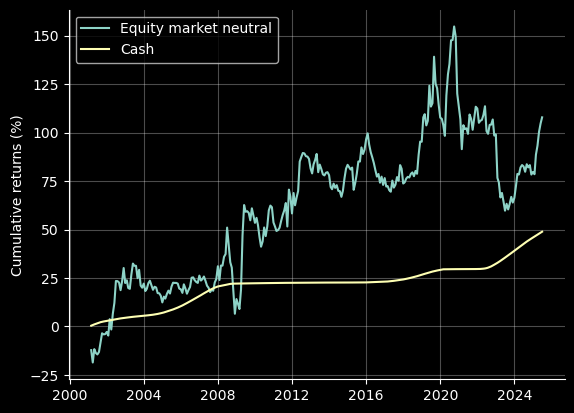

In [195]:
# get cumulative returns for market neutral strategy
market_equity_neutral_df['equity_neutral_cum'] = (1 + market_equity_neutral_df['equity_neutral']).cumprod() - 1
plot_data = market_equity_neutral_df.merge(irx_monthly, on='date')
plt.plot(plot_data['date'], plot_data['equity_neutral_cum'] * 100, label='Equity market neutral')
plt.plot(plot_data['date'], plot_data['cumulative_yield'] * 100, label='Cash')
plt.grid(alpha=0.3)
plt.legend()
plt.ylabel('Cumulative returns (%)')
sns.despine()

So we find some overperformance over the cash target, but we are certainly less confident with the equity market neutral strategy than we are with the alpha extension strategy. We can see that the returns in the early 2000s, and the drawdowns seen in 2008 and 2020/2021 are quite significant.

Consider the market beta for the equity market neutral strategy.

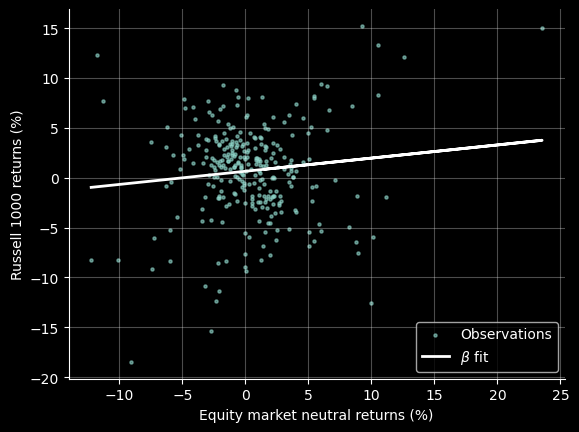

Beta: 0.1319


In [194]:

x = market_equity_neutral_df['equity_neutral'] * 100
y = market_equity_neutral_df['index'] * 100

# fit a line y = m*x + b
m, b = np.polyfit(x, y, 1)

plt.scatter(x, y, s=5, alpha=0.6, label="Observations")
plt.plot(x, m*x + b, color='white', linewidth=2, label="$\\beta$ fit")

plt.grid(alpha=0.3)
plt.xlabel('Equity market neutral returns (%)')
plt.ylabel('Russell 1000 returns (%)')
plt.legend()
sns.despine()
plt.show()

print(f'Beta: {round(m, 4)}')

So we have a $\beta$ of 0.13, which is a little more exposure than we wanted. It appears that most of the exposure is during drawdowns (which is not great; clients want the opposite of this).

In [199]:
sharpe = (market_equity_neutral_df['equity_neutral'].mean() * 12) / \
    (market_equity_neutral_df['equity_neutral'].std() * np.sqrt(12))
ann_return = (market_equity_neutral_df['equity_neutral'].mean() * 12)
ann_volatility = (market_equity_neutral_df['equity_neutral'].std() * np.sqrt(12))
print(f'Sharpe: {round(sharpe, 2)}')
print(f'Annualised return: {round(ann_return, 2)}')
print(f'Annualised volatility: {round(ann_volatility, 2)}')

Sharpe: 0.29
Annualised return: 0.04
Annualised volatility: 0.14
